In [4]:
import tensorflow as tf

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, preprocessing, optimizers

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
main_dir = "./dataset"
# classification_dirs = [("no_tumor",), ("meningioma_tumor",), ("glioma_tumor",), ("pituitary_tumor",) ]
# classification_dirs = [("no_tumor",), ("meningioma_tumor",) ]
# classification_dirs = [("no_tumor",), ("glioma_tumor",) ]
classification_dirs = [("no_tumor",), ("pituitary_tumor",) ]
# classification_dirs = [("glioma_tumor",), ("pituitary_tumor",) ]
# classification_dirs = [("meningioma_tumor",), ("pituitary_tumor",) ]
# classification_dirs = [("meningioma_tumor",), ("glioma_tumor",) ]

resolution = 64

def load_images(root_dir_name):
    x = []
    y = []
    
    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, color_mode="grayscale", target_size=(resolution, resolution))
                x.append(preprocessing.image.img_to_array(image))
                y.append(label)
    
    x = np.array(x) / 255.0
    y = np.array(y)
    
    return x, y

x_train, y_train = load_images("Training")
x_test, y_test = load_images("Testing")

print("done loading!")
print("\nshapes:")
print(x_train.shape)
print(x_test.shape)

loading Training no_tumor
loading Training pituitary_tumor
loading Testing no_tumor
loading Testing pituitary_tumor
done loading!

shapes:
(1222, 64, 64, 1)
(179, 64, 64, 1)


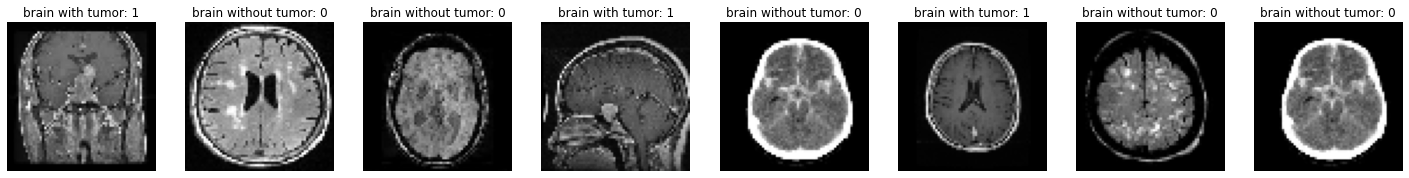

In [8]:
c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_test))
    num = y_test[n]
    word = "out" if num == 0 else ""
    
    subplots[i].imshow(x_test[n].reshape((resolution, resolution)), cmap="gray")
    subplots[i].set_title(f"brain with{word} tumor: {num}")
    subplots[i].axis("off")
plt.show()

In [9]:
model = keras.Sequential([
    layers.Input((resolution, resolution, 1)), # 64 x 64 x 1
    layers.Conv2D(32, (3, 3), activation="linear", padding="same"), # 64 X 64 X 32
    layers.MaxPooling2D(2, 2), # 32 x 32 x 32
    layers.Conv2D(64, (3, 3), activation="linear", padding="same"), #32 x 32 x64
    layers.MaxPooling2D(2, 2), # 16 x 16 x 64
    layers.Conv2D(128, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 8 x 8
    layers.Conv2D(32, (3, 3), activation="linear", padding="same"),
    layers.MaxPooling2D(2, 2), # 4 x 4
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="linear"), # 128 and 256 got 94% after 15 epochs
    layers.Dropout(0.5),
    layers.Dense(256, activation="linear"),
    layers.Dense(2, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          3

In [10]:
history = model.fit(x_train, y_train, batch_size=4, shuffle=True, epochs=15, validation_data=(x_test, y_test))

Epoch 1/15
306/306 [==============================] - 6s 10ms/step - loss: 0.4740 - accuracy: 0.8224 - val_loss: 0.4993 - val_accuracy: 0.8156
Epoch 2/15
306/306 [==============================] - 2s 6ms/step - loss: 0.2170 - accuracy: 0.9206 - val_loss: 0.1982 - val_accuracy: 0.9441
Epoch 3/15
306/306 [==============================] - 2s 5ms/step - loss: 0.1460 - accuracy: 0.9476 - val_loss: 0.1564 - val_accuracy: 0.9274
Epoch 4/15
306/306 [==============================] - 2s 7ms/step - loss: 0.1118 - accuracy: 0.9714 - val_loss: 0.2174 - val_accuracy: 0.9050
Epoch 5/15
306/306 [==============================] - 2s 6ms/step - loss: 0.0915 - accuracy: 0.9746 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 6/15
306/306 [==============================] - 2s 7ms/step - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.1050 - val_accuracy: 0.9330
Epoch 7/15
306/306 [==============================] - 1s 5ms/step - loss: 0.0618 - accuracy: 0.9885 - val_loss: 0.1226 - val_accuracy: 0.9441
Epoch

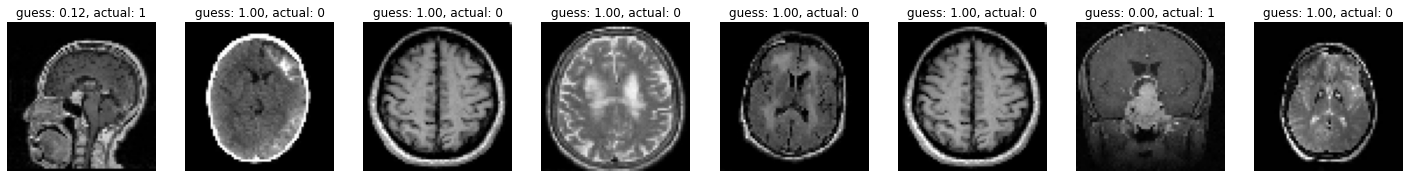

In [12]:
y_test_results = model.predict([x_test])

c = 8

fig, subplots = plt.subplots(1, c)
fig.set_size_inches(25, 3)
for i in range(c):
    n = np.random.randint(0, len(x_test))
    guess = str(round(y_test_results[n][0], 2)).ljust(4, "0")
    actual = y_test[n]

    subplot = subplots[i]
    subplot.imshow(x_test[n].reshape((resolution, resolution)), cmap="gray")
    subplot.set_title(f"guess: {guess}, actual: {actual}")
    subplot.axis("off")
plt.show()

In [13]:
main_dir = "./dataset"
# classification_dirs = [("no_tumor",), ("meningioma_tumor",), ("glioma_tumor",), ("pituitary_tumor",) ]
comb = {
    'no_tumor_to_meningioma_tumor': [("no_tumor",), ("meningioma_tumor",) ],
    'no_tumor_to_glioma_tumor': [("no_tumor",), ("glioma_tumor",) ],
    'no_tumor_to_pituitary_tumor': [("no_tumor",), ("pituitary_tumor",) ],
    'glioma_tumor_to_pituitary_tumor':[("glioma_tumor",), ("pituitary_tumor",) ],
    'meningioma_tumor_to_pituitary_tumor': [("meningioma_tumor",), ("pituitary_tumor",) ],
    'meningioma_tumor_to_glioma_tumor':[("meningioma_tumor",), ("glioma_tumor",) ]

}

dataset = {
    
}

resolution = 64

def load_images(root_dir_name, classification_dirs):
    x = []
    y = []
    
    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, color_mode="grayscale", target_size=(resolution, resolution))
                x.append(preprocessing.image.img_to_array(image))
                y.append(label)
    
    x = np.array(x) / 255.0
    y = np.array(y)
    
    return x, y

for key in comb:
    x_train, y_train = load_images("Training", comb[key])
    x_test, y_test = load_images("Testing", comb[key])
    
    dataset[key] = {
        'x_train': x_train,
        'y_train': y_train,
        'x_test': x_test,
        'y_test': y_test
    }

print("done loading!")

loading Training no_tumor
loading Training meningioma_tumor
loading Testing no_tumor
loading Testing meningioma_tumor
loading Training no_tumor
loading Training glioma_tumor
loading Testing no_tumor
loading Testing glioma_tumor
loading Training no_tumor
loading Training pituitary_tumor
loading Testing no_tumor
loading Testing pituitary_tumor
loading Training glioma_tumor
loading Training pituitary_tumor
loading Testing glioma_tumor
loading Testing pituitary_tumor
loading Training meningioma_tumor
loading Training pituitary_tumor
loading Testing meningioma_tumor
loading Testing pituitary_tumor
loading Training meningioma_tumor
loading Training glioma_tumor
loading Testing meningioma_tumor
loading Testing glioma_tumor
done loading!


In [14]:
def make_model():
    model = keras.Sequential([
        layers.Input((resolution, resolution, 1)),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2), # 32 x 32
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2), # 16 x 16
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2), # 8 x 8
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2), # 4 x 4
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"), # 128 and 256 got 94% after 15 epochs
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
    model.summary()
    
    return model

In [15]:
models = {}
historys = {}
for key in dataset:
    print("Key: {}".format(key))
    model = make_model()
    x_train = dataset[key]['x_train']
    x_test = dataset[key]['x_test']
    y_train = dataset[key]['y_train']
    y_test = dataset[key]['y_test']
    history = model.fit(x_train, y_train, batch_size=4, shuffle=True, epochs=50, validation_data=(x_test, y_test))
    
    models[key] = model
    historys[key] = history

Key: no_tumor_to_meningioma_tumor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)   

Epoch 38/50
305/305 [==============================] - 3s 9ms/step - loss: 0.6211 - accuracy: 0.7872 - val_loss: 0.6090 - val_accuracy: 0.5591
Epoch 39/50
305/305 [==============================] - 2s 8ms/step - loss: 0.7237 - accuracy: 0.7962 - val_loss: 0.5988 - val_accuracy: 0.5864
Epoch 40/50
305/305 [==============================] - 3s 8ms/step - loss: 0.6488 - accuracy: 0.8258 - val_loss: 0.6097 - val_accuracy: 0.5818
Epoch 41/50
305/305 [==============================] - 3s 9ms/step - loss: 0.5767 - accuracy: 0.8233 - val_loss: 0.8654 - val_accuracy: 0.5545
Epoch 42/50
305/305 [==============================] - 2s 7ms/step - loss: 0.5597 - accuracy: 0.8291 - val_loss: 1.0922 - val_accuracy: 0.5909
Epoch 43/50
305/305 [==============================] - 2s 6ms/step - loss: 0.7132 - accuracy: 0.7831 - val_loss: 1.5490 - val_accuracy: 0.6136
Epoch 44/50
305/305 [==============================] - 2s 8ms/step - loss: 0.5817 - accuracy: 0.7872 - val_loss: 0.7381 - val_accuracy: 0.5227

KeyboardInterrupt: 